# QAOA pour notre problème d'optimisation

In [35]:
#les modules
from qiskit.opflow import X, I, Z, PauliSumOp

from itertools import combinations
from qiskit import QuantumCircuit

import numpy as np

from qiskit.opflow import PauliTrotterEvolution, CircuitSampler #pour U_M et U_C

from qiskit import Aer, execute

from qiskit.opflow import StateFn, CircuitStateFn, PauliExpectation, AerPauliExpectation # Pour l'optimisation
from qiskit.utils import QuantumInstance

from scipy.optimize import minimize




In [36]:
# Les valeurs / exemples
n_qubits = 3  #n_qubits = P_i, un seul générateur → P_i qubits

P_i   = [3,3,3]          # granularité (3 qubits)
c_i   = [10,8,7]       # coût linéaire
D_i   = [30,20,10]        # demande (2 unités)
lam   = 5.0             # facteur de pénalité λ


In [37]:
#Définition de L'Hamiltonien de mélange
H_M = sum([PauliSumOp.from_list([('I'*i + 'X' + 'I'*(n_qubits-i-1), 1.0)]) for i in range(n_qubits)]) # Mixeur = somme des X_i

In [38]:
#Définition de L'Hamiltonien de coût
H_C = 0 * PauliSumOp.from_list([('I'*n_qubits, 0.0)])
for idx in range(len(c_i)):
    ci = c_i[idx]
    Di = D_i[idx]
    Pi = P_i[idx]
    
    def z_op(q):                       # Z sur le qubit q
        return PauliSumOp.from_list([('I'*q+'Z'+'I'*(n_qubits-q-1), 1.0)])
    Id = PauliSumOp.from_list([('I'*n_qubits, 1.0)])
    # g_i
    g_lin = (Pi/2) * Id
    for q in range(P_i[idx]):
        g_lin += (-0.5) * z_op(q)
    
    Hi = ci * g_lin
    
    Hi += lam * (-2*Di) * g_lin
    
    # g_i^2 termes
    # a) ZZ
    for p, q in combinations(range(Pi), 2):
        pauli = ['I'] * n_qubits
        pauli[p] = 'Z'
        pauli[q] = 'Z'
        Hi += lam * 0.25 * PauliSumOp.from_list([(''.join(pauli), 1.)])
    
    # b) Z simples
    for q in range(Pi):
        Hi += lam * (-Pi/4) * z_op(q)
    
    # somme sur i
    H_C += Hi

In [39]:
# Définition des opérateurs

evolution = PauliTrotterEvolution()

def U_C(gamma, H):
    return evolution.convert((gamma * H).exp_i()).to_circuit()

def U_M(beta, H):
    return evolution.convert((beta * H).exp_i()).to_circuit()


In [40]:
# Construction du circuit QAOA
def build_qaoa_circuit(n, p, gammas, betas, cost_h, mixer_h):
    qc = QuantumCircuit(n, n)
    qc.h(range(n))                      # état initial |+...+>
    for layer in range(p):
        qc.append(U_C(float(gammas[layer]), cost_h), range(n))
        qc.append(U_M(float(betas[layer]), mixer_h), range(n))
    qc.measure(range(n), range(n))  # Mesure tous les qubits
    return qc


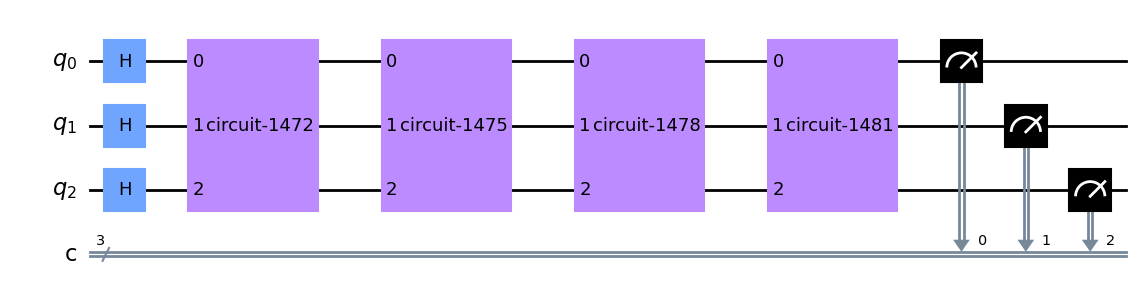

In [41]:
n=3
p=2 
gammas=[np.pi/4, np.pi/2]
betas=[np.pi/8, np.pi/4]
params=[np.pi/4, np.pi/2, np.pi/8, np.pi/4 ]
cost_h=H_C
mixer_h=H_M
qc=build_qaoa_circuit(n,p,gammas,betas,cost_h,mixer_h)
qc.draw("mpl")

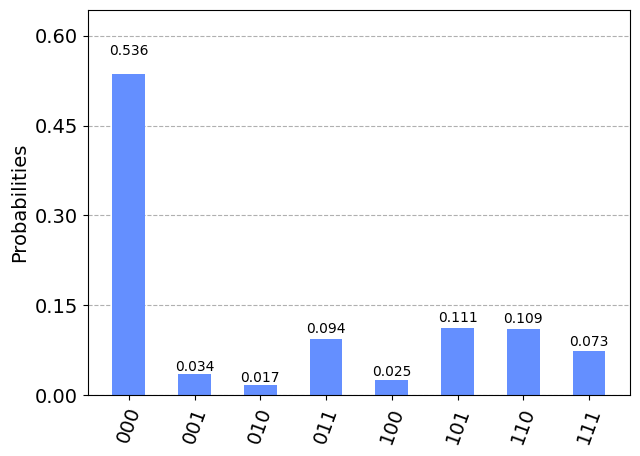

In [42]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
result = job.result()
counts = result.get_counts()

# Affichage les résultats de mesure
from qiskit.visualization import plot_histogram
plot_histogram(counts)
